<a href="https://colab.research.google.com/github/limweiliang/weed-classifier/blob/main/CS3244_ProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Nov  9 13:58:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P5    14W /  N/A |   1323MiB /  6144MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9

# ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)
# images, labels = ds['train'] # Type: EagerTensor

# # Shuffle the dataset
# images = tf.random.shuffle(images, seed=RANDOM_STATE)
# labels = tf.random.shuffle(labels, seed=RANDOM_STATE)

# print(images.shape, labels.shape)

# # Split dataset into train-val-test
# num_images = images.shape[0]
# last_train_image = math.floor(num_images * 0.6)
# last_val_image = math.floor(num_images * 0.8)

# X_train = images[:last_train_image]
# y_train = labels[:last_train_image]
# X_val = images[last_train_image:last_val_image]
# y_val = labels[last_train_image:last_val_image]
# X_test = images[last_val_image:]
# y_test = labels[last_val_image:]

# print(X_train.shape, X_val.shape, X_test.shape)

In [6]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

def add_grey_grad(img ,label):
    org_img = img
    img = tf.cast(img, float)
    #img = tf.expand_dims(img, axis = 0)
    gray = tf.image.rgb_to_grayscale(img)
    dy , dx = tf.image.image_gradients(gray)
    dmag = tf.math.sqrt(tf.add(tf.math.square(dy),tf.math.square(dx)))

    #Normalize to 0 - 255
    im_max = tf.math.reduce_max(dmag)
    im_min = tf.math.reduce_min(dmag)
    out = (tf.math.subtract(dmag, im_min) / (im_max - im_min)) * 255
    out = tf.expand_dims(tf.cast(out, tf.uint8), axis = 0)
    out = tfa.image.gaussian_filter2d(out[0])
    
    gray = tf.expand_dims(tf.cast(gray, tf.uint8), axis = 0)
    org_img = tf.concat([org_img,gray[0],out],-1)
    return (org_img, label)

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.map(add_grey_grad)
validation_ds = validation_ds.map(add_grey_grad)
test_ds = test_ds.map(add_grey_grad)


train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 96
Number of validation samples: 28
Number of test samples: 14


In [7]:
# Clean up memory usage
# del ds
# del images
# del labels

In [8]:
from tensorflow.keras import datasets, layers, models, regularizers, Input
import datetime

In [54]:
inputs = Input(shape = (256,256,5), name = "Original_Image")
flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
rotate = layers.RandomRotation((-0.5,0.5), fill_mode = "nearest")(flip)
rescale = layers.Rescaling(1/255)(rotate)

x = layers.Conv2D(32, (3,3), padding = "same", strides = 2)(rescale)
x = layers.Conv2D(64, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_1_output = layers.MaxPool2D(3,3)(x)

x = layers.Conv2D(128, (3,3), padding = "same")(block_1_output)
x = layers.Conv2D(128, (3,3), padding = "same")(x)
x = layers.BatchNormalization()(x)
block_2_output = layers.ReLU()(x)

x = layers.Conv2D(128, (3,3), padding = "same")(block_2_output)
x = layers.Conv2D(128, (3,3), padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.add([block_2_output,x])
block_3_output = layers.ReLU()(x)

x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(block_3_output)
x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_4_output = layers.MaxPool2D()(x)

x = layers.Flatten()(block_4_output)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="4_block_Resnet")
model.summary()

Model: "4_block_Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_Image (InputLayer)     [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
random_flip_21 (RandomFlip)     (None, 256, 256, 5)  0           Original_Image[0][0]             
__________________________________________________________________________________________________
random_rotation_21 (RandomRotat (None, 256, 256, 5)  0           random_flip_21[0][0]             
__________________________________________________________________________________________________
rescaling_21 (Rescaling)        (None, 256, 256, 5)  0           random_rotation_21[0][0]         
_____________________________________________________________________________________

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)


model.compile(optimizer=optimizer,
              loss= 'categorical_crossentropy',
              metrics=["Precision", "Recall",'accuracy'])

In [56]:
model.summary()

Model: "4_block_Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_Image (InputLayer)     [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
random_flip_21 (RandomFlip)     (None, 256, 256, 5)  0           Original_Image[0][0]             
__________________________________________________________________________________________________
random_rotation_21 (RandomRotat (None, 256, 256, 5)  0           random_flip_21[0][0]             
__________________________________________________________________________________________________
rescaling_21 (Rescaling)        (None, 256, 256, 5)  0           random_rotation_21[0][0]         
_____________________________________________________________________________________

In [57]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True , verbose = 1)

#Constant learning rate for first N epochs then it decreases exponentially
# def scheduler(epoch, lr):
#   if epoch < 65:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1/5)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

checkpoint_filepath = "./CNN_Models/4_block_Resnet/4_blockResnetV1.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [58]:
hist = model.fit(train_ds, epochs=200,
                     validation_data= validation_ds, callbacks=[EarlyStop, reduce_lr, model_checkpoint_callback],batch_size = BATCH_SIZE)

Epoch 1/200
96/96 [==============================] - 20s 189ms/step - loss: 2.9459 - precision: 0.5268 - recall: 0.3486 - accuracy: 0.4674 - val_loss: 2.1048 - val_precision: 0.2604 - val_recall: 0.0143 - val_accuracy: 0.5103

Epoch 00001: val_loss improved from inf to 2.10480, saving model to ./CNN_Models/4_block_Resnet\4_blockResnetV1.h5
Epoch 2/200
96/96 [==============================] - 17s 182ms/step - loss: 1.4603 - precision: 0.7061 - recall: 0.3743 - accuracy: 0.5194 - val_loss: 1.9143 - val_precision: 0.7305 - val_recall: 0.3389 - val_accuracy: 0.5103

Epoch 00002: val_loss improved from 2.10480 to 1.91434, saving model to ./CNN_Models/4_block_Resnet\4_blockResnetV1.h5
Epoch 3/200
96/96 [==============================] - 18s 193ms/step - loss: 1.3580 - precision: 0.7476 - recall: 0.3765 - accuracy: 0.5355 - val_loss: 3.2349 - val_precision: 0.5176 - val_recall: 0.5083 - val_accuracy: 0.5100

Epoch 00003: val_loss did not improve from 1.91434
Epoch 4/200
96/96 [===============

96/96 [==============================] - 21s 215ms/step - loss: 0.3061 - precision: 0.9146 - recall: 0.8708 - accuracy: 0.8899 - val_loss: 1.2866 - val_precision: 0.7504 - val_recall: 0.7296 - val_accuracy: 0.7387

Epoch 00057: val_loss did not improve from 1.16364
Epoch 58/200
96/96 [==============================] - 21s 214ms/step - loss: 0.3052 - precision: 0.9139 - recall: 0.8685 - accuracy: 0.8898 - val_loss: 1.0755 - val_precision: 0.7741 - val_recall: 0.7439 - val_accuracy: 0.7556

Epoch 00058: val_loss improved from 1.16364 to 1.07548, saving model to ./CNN_Models/4_block_Resnet\4_blockResnetV1.h5
Epoch 59/200
96/96 [==============================] - 20s 211ms/step - loss: 0.2969 - precision: 0.9182 - recall: 0.8766 - accuracy: 0.8963 - val_loss: 1.0204 - val_precision: 0.7824 - val_recall: 0.7599 - val_accuracy: 0.7673

Epoch 00059: val_loss improved from 1.07548 to 1.02043, saving model to ./CNN_Models/4_block_Resnet\4_blockResnetV1.h5
Epoch 60/200
96/96 [====================


Epoch 00112: val_loss did not improve from 0.61084
Epoch 113/200
96/96 [==============================] - 19s 194ms/step - loss: 0.1185 - precision: 0.9643 - recall: 0.9535 - accuracy: 0.9590 - val_loss: 0.8065 - val_precision: 0.8447 - val_recall: 0.8355 - val_accuracy: 0.8392

Epoch 00113: val_loss did not improve from 0.61084
Epoch 114/200
96/96 [==============================] - 19s 195ms/step - loss: 0.1203 - precision: 0.9659 - recall: 0.9526 - accuracy: 0.9587 - val_loss: 0.8622 - val_precision: 0.8436 - val_recall: 0.8318 - val_accuracy: 0.8367

Epoch 00114: val_loss did not improve from 0.61084
Epoch 115/200
96/96 [==============================] - 19s 194ms/step - loss: 0.1190 - precision: 0.9633 - recall: 0.9521 - accuracy: 0.9577 - val_loss: 0.8074 - val_precision: 0.8513 - val_recall: 0.8372 - val_accuracy: 0.8429

Epoch 00115: val_loss did not improve from 0.61084
Epoch 116/200
96/96 [==============================] - 19s 194ms/step - loss: 0.1178 - precision: 0.9652 - r

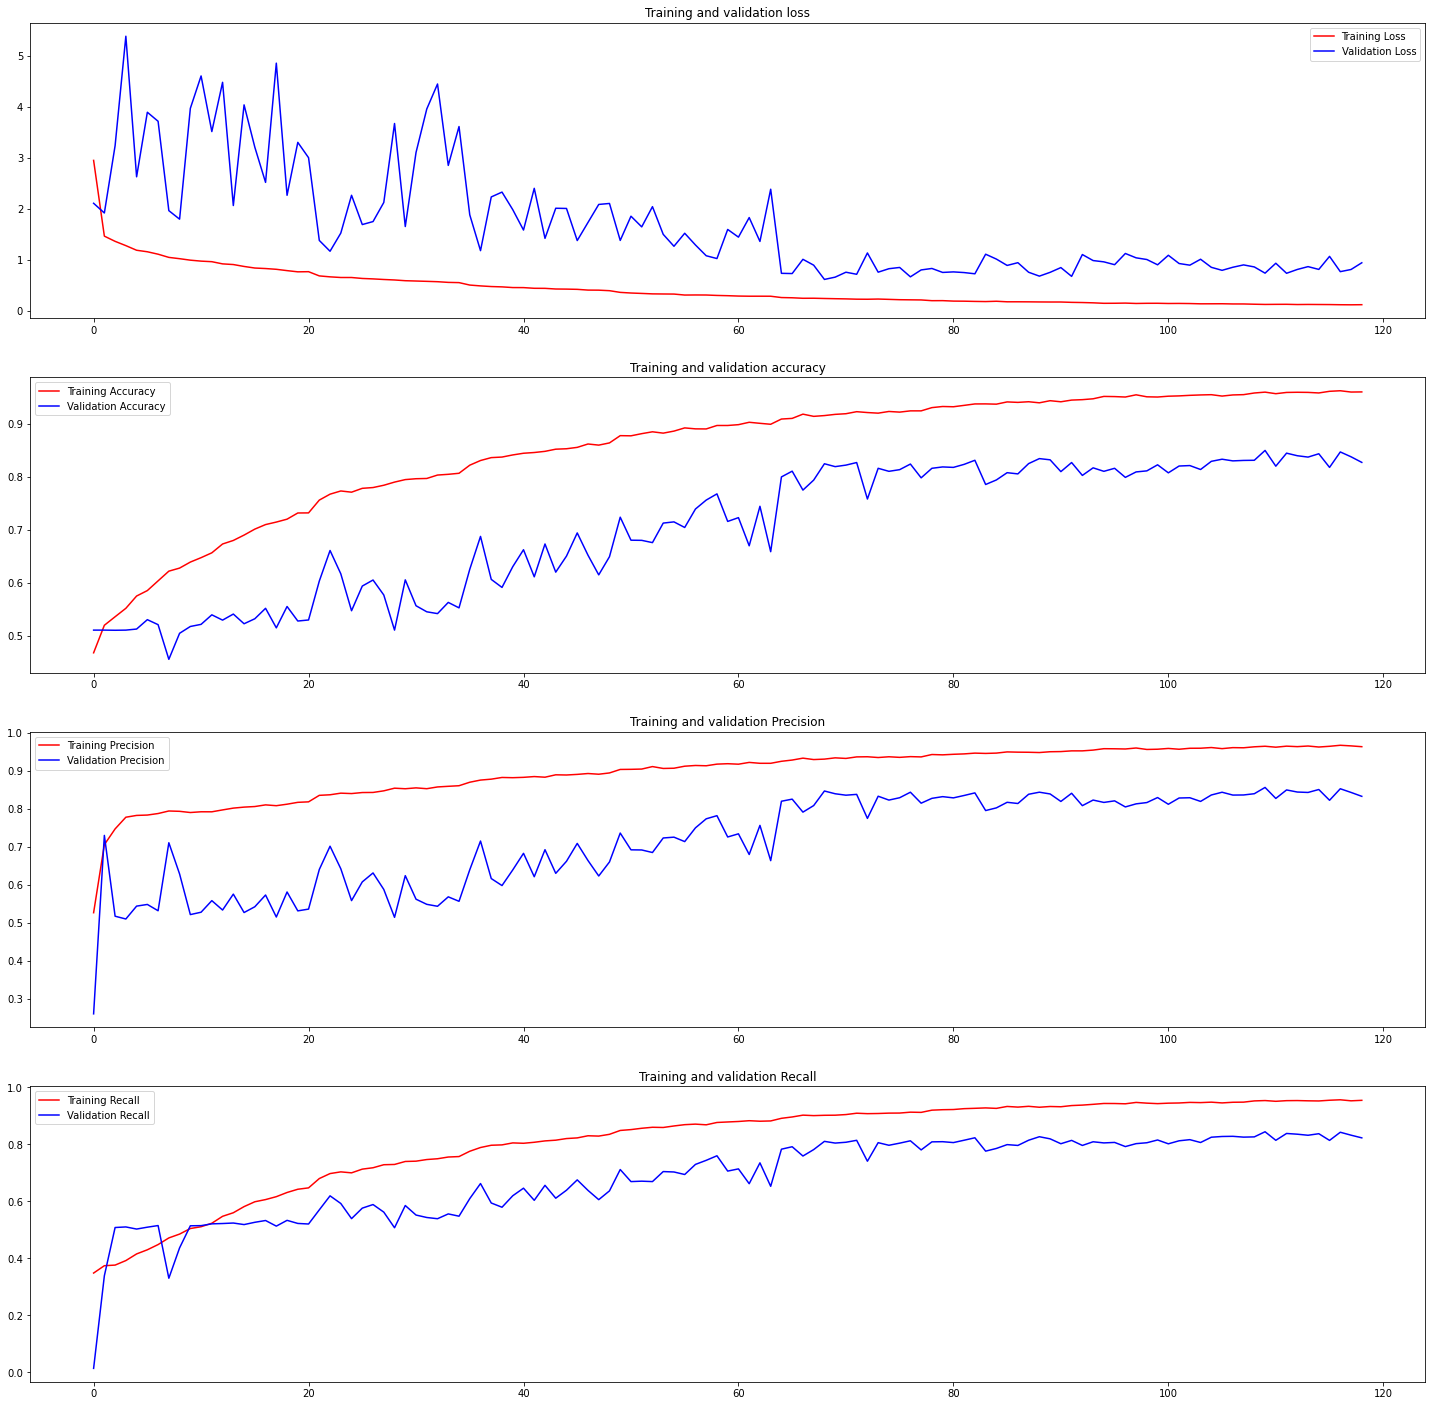

In [59]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(25, 25))
plt.subplot(4, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(epochs, recall, 'r', label = "Training Recall")
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

In [60]:
model.evaluate(validation_ds)

28/28 [==============================] - 2s 53ms/step - loss: 0.6108 - precision: 0.8474 - recall: 0.8104 - accuracy: 0.8241


[0.610844612121582, 0.8474171161651611, 0.8103940486907959, 0.8241004943847656]

In [163]:
#model.save('./CNN_Models/4_block_Resnet/4_blockResnetV1.h5')

In [5]:
model = models.load_model('CNN_Models/4_block_Resnet/4_blockResnetV1.h5')

In [6]:
model.summary()

Model: "2_block_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip_29 (RandomFlip)  (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation_29 (RandomRo (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling_29 (Rescaling)     (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 128, 128, 64)      2944      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 64, 64, 64)        

In [7]:
model.compile()

In [15]:
test = tfds.as_numpy(test_ds)
y_pred = []
y_label = []

for i in test:
  flat_img = i[0]
  flat_label = i[1]
  pred = model.predict(flat_img)
  pred = np.argmax(pred, axis=1)
  y_pred.extend(pred)
  y_label.extend(np.argmax(flat_label, axis = 1))

y_pred = np.array(y_pred)
y_label = np.array(y_label)

In [16]:
len(y_pred)

1751

In [17]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(y_label, y_pred))

[8 8 8 ... 8 2 8]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       103
           1       0.91      0.81      0.86        90
           2       0.94      0.85      0.90       116
           3       0.81      0.91      0.86       105
           4       0.80      0.83      0.82       108
           5       0.93      0.85      0.89        98
           6       0.92      0.86      0.89       114
           7       0.85      0.88      0.87       129
           8       0.92      0.95      0.93       888

    accuracy                           0.89      1751
   macro avg       0.88      0.85      0.86      1751
weighted avg       0.89      0.89      0.89      1751

